
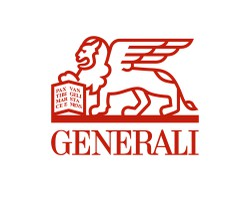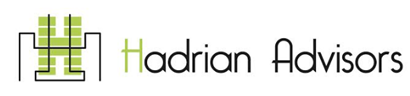

# Insurance Usecase

# Introduction to Neural Network Methodology in <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> : Feed-Forward and Back-propagation in a One-Layer Neural Network 

## 1. Data Preparation

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn
import gc
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

In [3]:
## read datasets
pathData = ''

train = pd.read_csv(pathData+'trainDataset.csv')
Y = train['target'].as_matrix()
DF_X = train.drop('target',axis=1)

test =  pd.read_csv(pathData+'testDataset.csv')
Y_test = test['target'].as_matrix()
DF_X_test = test.drop('target',axis=1)


In [4]:
## Transform the types of each column
for c in DF_X.columns:
    if 'Cat_' in c:
        DF_X[c] = DF_X[c].astype(str)
        DF_X_test[c] = DF_X_test[c].astype(str)
    else:
        DF_X[c] = DF_X[c].astype(float)
        DF_X_test[c] = DF_X_test[c].astype(float)

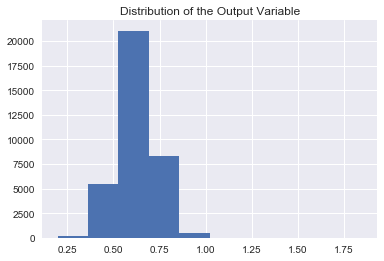

In [5]:
## Hist Expected loss ratio
plt.hist(Y)
plt.title('Distribution of the Output Variable')
plt.show()

### Categorization of the output variable

In [6]:
# Categorization
treshold_ExLR = 0.75

Id_0_train = np.nonzero(Y<treshold_ExLR)[0]
Id_0_test = np.nonzero(Y_test<treshold_ExLR)[0]

Id_1_train = np.nonzero(Y>=treshold_ExLR)[0]
Id_1_test = np.nonzero(Y_test>=treshold_ExLR)[0]

Y[Id_0_train] = 0
Y[Id_1_train] = 1

Y_test[Id_0_test] = 0
Y_test[Id_1_test] = 1

### Encoding the categorical variables

In [7]:
# Encode categorical variables
DF_X = DF_X.copy()
DF_X_test = DF_X_test.copy()
for var in DF_X.columns:
    if str(DF_X[var].dtypes)=='object':
        le = LabelEncoder().fit(DF_X[var])
        DF_X[var] = le.transform(DF_X[var])
        DF_X_test[var] = le.transform(DF_X_test[var])

## 2. Get the most important features

We want to use the most important features in DF_X using the Random Forest Classifier. The Gini criterion would be useful to do so.

In [8]:

# Var importance using RF classifier
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(random_state=0, n_estimators=100,\
                                  criterion='gini',max_depth=5)
VarImp = estimator.fit(DF_X,Y).feature_importances_

In [9]:
VarToUse = np.array(DF_X.columns.tolist())[np.argsort(-VarImp)[:10]]
print("List of the 10 features to use : ")
print(VarToUse)

List of the 10 features to use : 
['Num_Car11' 'Num_Car15' 'Num_Car9' 'NumInsurance13' 'NumInsurance11'
 'Cat_Insurance4' 'Cat_Insurance3' 'NumInsurance12' 'Num_Car19'
 'NumInsurance16']


**We can now extract these features, along with a random sample of the rows.**

In [10]:
# Sampling

sizeSample = 5000
IdRand = np.sort(np.random.permutation(np.arange(len(Y)))[:sizeSample])
X_sample = DF_X[VarToUse].as_matrix()[IdRand]
Y_sample = Y[IdRand]

X_test = DF_X_test[VarToUse].as_matrix()

print('X sample')
print(X_sample[:5])

print
print('Y sample')
print(Y_sample[:5])

X sample
[[  3.00000000e+00   2.00000000e+00   1.37080000e+04   4.50726853e+03
    3.47754683e+02   2.00000000e+00   2.00000000e+00   7.71541967e-02
    9.39000000e+02   5.13554623e+03]
 [  1.40000000e+01   1.00000000e+00   4.70000000e+03   1.62568068e+03
    1.92037273e+02   1.00000000e+00   1.00000000e+00   1.18127302e-01
    9.30000000e+02   4.69981257e+03]
 [  1.60000000e+01   1.00000000e+00   7.20000000e+03   1.91970477e+03
    3.12497936e+02   1.00000000e+00   1.00000000e+00   1.62784372e-01
    1.28900000e+03   4.76394525e+03]
 [  1.60000000e+01   1.00000000e+00   6.30000000e+03   2.06749247e+03
    3.20496845e+02   1.00000000e+00   1.00000000e+00   1.55017176e-01
    1.37500000e+03   4.60598510e+03]
 [  2.50000000e+01   1.00000000e+00   0.00000000e+00   2.33148509e+03
    3.26944564e+02   1.00000000e+00   1.00000000e+00   1.40230175e-01
    1.02100000e+03   6.30464816e+03]]

Y sample
[ 0.  1.  0.  0.  0.]


### 3. Benchmark : GLM Application
**We are making a benchmark for the next tests : let's compute a linear regression on our data to fit the Output Variable.**

In [11]:
from sklearn import linear_model
from sklearn import metrics

glm = linear_model.LinearRegression()
glm.fit(X_sample,Y_sample)
prediction = glm.predict(DF_X[VarToUse].as_matrix())

Let's compute te ROC curves on the training set and the test set :

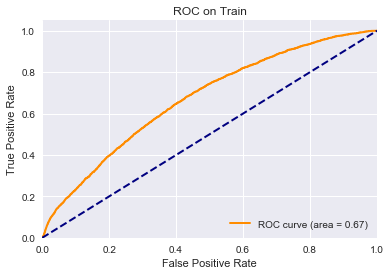

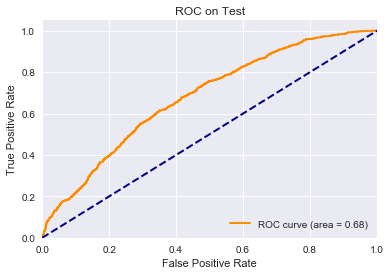

In [12]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(Y,prediction)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on Train')
plt.legend(loc="lower right")
plt.show()


fpr_test, tpr_test, _ = roc_curve(\
                Y_test,glm.predict(DF_X_test[VarToUse].as_matrix()))
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on Test')
plt.legend(loc="lower right")
plt.show()

In [13]:
prediction

array([ 0.14466794,  0.16599344, -0.04421585, ...,  0.12704303,
        0.16501685,  0.14778655])

### 4. One Hidden Layer Neural network : Implementation

Let's define error functions and their cost derivatives :

In [14]:
def MSE(y,ychap):
    return sum((ychap-y)**2)


def MSEDer(y,ychap):
    return (ychap-y)


Let's define some activation functions and their derivatives; by default, we will take the sigmoid function.

In [15]:
# activation function in this case Sigmoid
def sigmoid(x): 
    return 1./(1+np.exp(-x))     # activation function

def sigmoid_prime(x): 
    return sigmoid(x)*(1-sigmoid(x))           # derivative of sigmoid

# activation function of Exponential linear unit
def ELU(x):
    res = 0.01 * (np.exp(x) - 1) * (x < 0) + x * (x >= 0)
    return res

# Derivative of Exponential linear unit
def ELU_prime(x):
    res = (ELU(x) + 0.01) * (x < 0) + 1.0 * (x >= 0)
    return res

# activation function of Rectified linear unit
def ReLU(x):
    res = 0.01*x*(x < 0) + x * (x >= 0)
    return res

# Derivative of Rectified linear unit
def ReLU_prime(x):
    res = 1.0 * (x >= 0) + 0.01 * (x < 0)
    
    return res

**/!\ Make sure to normalize your data before processing the propagation! **

In [16]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
normX = MinMaxScaler()
normX.fit(X_sample)
X_sample_norm = normX.transform(X_sample)
X_test_norm = normX.transform(X_test)

In [17]:
def encode_label(j):
    e = np.zeros((2, 1))
    e[int(j)] = 1.0
    return e


def shape_data(data, encode=True):
    features = [x for x in data[0]]
    if encode:
        labels = [encode_label(y) for y in data[1]]
    else:
        labels = data[1]
    return list(zip(features, labels))

**Merge X and Y**

In [18]:
train_data = (X_sample_norm, Y_sample)
test_data = (X_test_norm, Y_test)

train_data = shape_data(train_data, encode=False)
test_data = shape_data(test_data, encode=False)

print(train_data[0])

(array([ 0.05454545,  0.33333333,  0.07472214,  0.22869296,  0.09818904,
        0.5       ,  0.5       ,  0.09240681,  0.17438424,  0.26156041]), 0.0)


In [19]:
Y_encoded = [val[1] for val in train_data]

#### a) Initialization and test on one example (row)

**Let's try the process on one example.**

*INITIALIZATION*

In [20]:
# initial weight
W = np.random.random((1,X_sample_norm.shape[1]))
# initial bias
b = np.random.random((1,1))

# initialize the weight errors
delta_W = np.zeros(W.shape)

# initialize the bias errors
delta_b = np.zeros(b.shape)

print('W format : ')
print(W.shape)
print
print('b format : ')
print(b.shape)


W format : 
(1L, 10L)

b format : 
(1L, 1L)




*FORWARD PROPAGATION*

In [21]:
x = X_sample_norm[0:1]

## forward propagation
InputLayer = x.T

## Dense Layer
Layer = np.dot(W,InputLayer)+b

## Activation Layer
ActivationLayer = sigmoid(Layer)


print(' X = InputLayer,  input matrix')
print(InputLayer.shape)

print

print(' X = DenseLayer')
print(Layer.shape)

print

print('ActivationLayer after activation function')
print(ActivationLayer.shape)

 X = InputLayer,  input matrix
(10L, 1L)

 X = DenseLayer
(1L, 1L)

ActivationLayer after activation function
(1L, 1L)


*ACTIVATION ERROR*

*Let's compute the error of activation; We assume that we are using the MSE (Mean Squared Error)*

In [22]:
costType = 1

## Error computation
errorFunc = MSEDer
error = errorFunc(Y_encoded[0], ActivationLayer)
print(error)

[[ 0.81433404]]


*BACK PROPAGATION*

In [23]:
# Error correction: multiply the error by the slope of the activation
# function at Layer values

## => back propagation steps
ActivationLayer_d = error * sigmoid_prime(Layer)
print('Delta Error on Activaton Layer, Format :')
print(ActivationLayer_d.shape)

print

## Updating the errors on the weights and the biases
delta_W += np.dot(ActivationLayer_d,InputLayer.T)
delta_b += ActivationLayer_d

print('Weight Error, Format :')
print(delta_W.shape)
print
print('Bias Error, Format :')
print(delta_b.shape)


Delta Error on Activaton Layer, Format :
(1L, 1L)

Weight Error, Format :
(1L, 10L)

Bias Error, Format :
(1L, 1L)


*UPDATING THE WEIGHT AND THE BIAS*

In [24]:
# W becomes :
W -= delta_W

# b becomes :
b -= delta_b


Here are the results from that computation : 

In [25]:
print('W :')
print(W)
print
print('b :')
print(b)

W :
[[ 0.58634671  0.42656549  0.07197055  0.2114695   0.02228543  0.74742877
   0.93042103  0.44284701  0.63418607  0.4721744 ]]

b :
[[-0.08588123]]


**b) Iterations on each example in train_data (the training set)**

Let's compute that algorithm on every example from the training set.

In [26]:
## initial weight and bias

costType = 1

input_dim = len(train_data[0][0])
W = np.random.random((1,input_dim))
b = np.random.random((1,1))

delta_W = np.zeros(W.shape)
delta_b = np.zeros(b.shape)

for x, y in train_data:
    ## forward propagation
    InputLayer = np.vstack(x)
    Layer = np.dot(W,InputLayer)+b
    ActivationLayer = sigmoid(Layer)
    
    ## Error computation
    errorFunc = MSEDer
    error = errorFunc(y,ActivationLayer)
    
    ## => back propagation steps
    ActivationLayer_d = error * sigmoid_prime(Layer)
    
    ## Update the W errors and the b errors
    delta_W += np.dot(ActivationLayer_d,InputLayer.T)
    delta_b += ActivationLayer_d

## Updating W and B
W -= 0.1/len(train_data)*delta_W
b -= 0.1/len(train_data)*delta_b

We can define a Prediction function, given the weights and biases.

In [27]:
def Predict(X,W,b):
    nnetPred = sigmoid(np.dot(W,X.T)+b)
    
    return nnetPred[0]

In [28]:
# prediction on train sample
X_train_norm = normX.transform(DF_X[VarToUse].as_matrix())
nnetPredTrain = Predict(X_train_norm,W,b)

# prediction on test sample
X_test_norm = normX.transform(DF_X_test[VarToUse].as_matrix())
nnetPredTest = Predict(X_test_norm,W,b)


In [29]:
print('Prediction on Training Set, Format :')
print(nnetPredTrain.shape)
print

print('Prediction on Test Set, Format :')
print(nnetPredTest.shape)

Prediction on Training Set, Format :
(35572L,)

Prediction on Test Set, Format :
(8893L,)


#### c) Epochs and Mini_batchs :

In order to update the weight matrix and the bias vector on "batches" of the training set, ie in order to fit the model faster using groups of points, we could use the "mini-batch" method : we split the dataset in samples of the same size, and we compute the forward-propagation and back-propagation on these subsets; then we update the weights and the biases.



** Exercice ** :

Complete the function below, using our previous code, that enables to update *W*, *b*, given a subset of examples in *mini_batch* and *alpha* a learning rate.

In [34]:
def Train_Batch(mini_batch,W,b,costType=1,alpha=0.1):
    """
    Updates the weight matrix W and the bias vector b of a one-layer neural network, given a mini-batch of examples
    and alpha the learning rate.
    
    Arguments:
    mini_batch -- learning set
    W -- weight matrix
    b -- bias vector
    alpha -- learning rate
    
    Returns:
    W -- updated weight matrix
    b -- updated bias vector
    
    
    """
    
    delta_W = np.zeros(W.shape)
    delta_b = np.zeros(b.shape)
    for x, y in mini_batch:
        # forward propagation
        InputLayer = None
        Layer = None
        ActivationLayer = None
        ############### ENTER YOUR CODE HERE ################
        InputLayer = np.vstack(x)
        Layer = np.dot(W,InputLayer)+b
        ActivationLayer = sigmoid(Layer)
        ############### END OF THE CODE ################

        # Error computation
        errorFunc = MSEDer
        error = errorFunc(y, ActivationLayer)

        # => back propagation steps
        ActivationLayer_d = error * sigmoid_prime(Layer)

        delta_W += 0
        delta_b += 0
        ############### ENTER YOUR CODE HERE ################
        delta_W += np.dot(ActivationLayer_d,InputLayer.T)
        delta_b += ActivationLayer_d
        ############### END OF THE CODE ################
    W -= alpha/len(mini_batch)*delta_W
    b -= alpha/len(mini_batch)*delta_b
    return W, b

Another idea widely used is to compute the neural network multiple times on the examples, to measure the convergence of your algorithm. We iterate over the training set and look at the accuracy at each epoch.

**Exercice ** :

Complete the script below, that iterates 50 times over the training set and creates mini_batches.

In [35]:
costType = 0

## initial alpha
alpha = 0.1
mini_batch_size = 10
n_train = len(train_data)

## Initial W and b
W = np.random.random((1,X_sample_norm.shape[1]))
b = np.random.random((1,1))

## Iterates over the epochs :
for epochs in range(50):
    if epochs % 2 == 0:
        print(epochs)
    # shuffle the raining set to then split it into mini_batches :
    np.random.shuffle(train_data)
    mini_batches = [train_data[k:k + mini_batch_size]
                    for k in range(0, n_train, mini_batch_size)]
    for mini_batch in mini_batches:
        W += 0
        b += 0
        ## Train on Batch
        ########## ENTER YOUR CODE HERE #############
        W,b = Train_Batch(mini_batch,W,b,costType,alpha)
        ########## END OF THE CODE #############
    
    ## Accuracy computation :
    X_train_norm = normX.transform(DF_X[VarToUse].as_matrix())
    nnetPredTrain = Predict(X_train_norm,W,b)
    nnetPredTrain = np.round(nnetPredTrain)
    acc = (1. * np.sum(nnetPredTrain == Y)) / Y.shape[0]
    print(alpha)
    if epochs % 2 == 0:
        print("Accuracy for epoch " + str(epochs) + " : " + str(acc))
        print
    
    

0
0.1
Accuracy for epoch 0 : 0.893933430788

0.1
2
0.1
Accuracy for epoch 2 : 0.893933430788

0.1
4
0.1
Accuracy for epoch 4 : 0.893933430788

0.1
6
0.1
Accuracy for epoch 6 : 0.893933430788

0.1
8
0.1
Accuracy for epoch 8 : 0.893933430788

0.1
10
0.1
Accuracy for epoch 10 : 0.893933430788

0.1
12
0.1
Accuracy for epoch 12 : 0.893933430788

0.1
14
0.1
Accuracy for epoch 14 : 0.893933430788

0.1
16
0.1
Accuracy for epoch 16 : 0.893933430788

0.1
18
0.1
Accuracy for epoch 18 : 0.893933430788

0.1
20
0.1
Accuracy for epoch 20 : 0.893933430788

0.1
22
0.1
Accuracy for epoch 22 : 0.893933430788

0.1
24
0.1
Accuracy for epoch 24 : 0.893933430788

0.1
26
0.1
Accuracy for epoch 26 : 0.893933430788

0.1
28
0.1
Accuracy for epoch 28 : 0.893933430788

0.1
30
0.1
Accuracy for epoch 30 : 0.893933430788

0.1
32
0.1
Accuracy for epoch 32 : 0.893933430788

0.1
34
0.1
Accuracy for epoch 34 : 0.893933430788

0.1
36
0.1
Accuracy for epoch 36 : 0.893933430788

0.1
38
0.1
Accuracy for epoch 38 : 0.89393343

** Prediction on training and test sets ** :

In [36]:
# prediction on train sample
X_train_norm = normX.transform(DF_X[VarToUse].as_matrix())
nnetPredTrain = Predict(X_train_norm,W,b)

# prediction on test sample
X_test_norm = normX.transform(DF_X_test[VarToUse].as_matrix())
nnetPredTest = Predict(X_test_norm,W,b)


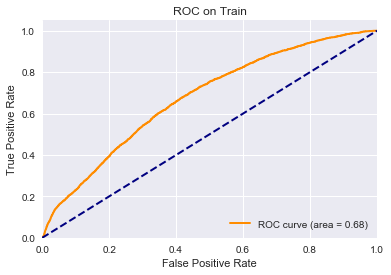

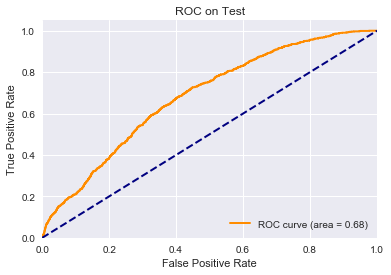

In [37]:
fpr, tpr, _ = roc_curve(Y.astype(int),nnetPredTrain)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on Train')
plt.legend(loc="lower right")
plt.show()


fpr_test, tpr_test, _ = roc_curve(\
                Y_test,nnetPredTest)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on Test')
plt.legend(loc="lower right")
plt.show()

In [38]:
nnetPredTrain

array([ 0.10758079,  0.14419629,  0.02618447, ...,  0.1244529 ,
        0.14768091,  0.13225803])